In [1]:
import pandas as pd
import numpy as np

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score,\
recall_score, roc_auc_score, confusion_matrix, classification_report

warnings.filterwarnings(action='ignore')
plt.rc('font', family='Noto Sans CJK JP')

In [2]:
df_all = pd.read_csv('ALL_DF.csv',engine='python',encoding='cp949')
indexNames = df_all[df_all['income_ind_grp'] =='모름/무응답'].index
df_new = df_all.drop(indexNames, inplace=False)
df_new = df_new.drop(['chaju_id','credit_class','score_risk','gender','age','agegroup',
            'job','edu','dwell_type','house_type', 'marriage',
            'income_home_grp', 'income_ind_grp', 'expenditure_grp', 
             'child_cd','no_child','flag_priv_biz_cd'],axis=1)
df_new = df_new.fillna(0)

In [3]:
df_new

,Unnamed: 0,card_count,card_period,loan_amt,loan_period,over_amt,over_period,연체율
0,0,4.0,99.0,70300000.0,79.0,5700000.0,2.0,8.108108
2,2,2.0,50.0,391000000.0,79.0,0.0,0.0,0.000000
4,4,3.0,75.0,367200000.0,40.0,0.0,0.0,0.000000
5,5,2.0,7.0,218000000.0,55.0,0.0,0.0,0.000000
7,7,7.0,167.0,78910000.0,110.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
1977,1977,0.0,0.0,860000.0,25.0,500000.0,6.0,58.139535
1979,1979,1.0,25.0,68000000.0,29.0,0.0,0.0,0.000000
1980,1980,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
1981,1981,5.0,104.0,0.0,0.0,0.0,0.0,0.000000


In [4]:
df_raw = pd.read_csv("df_raw_dummy.csv",engine='python')
df=pd.merge(df_raw,df_new, on='Unnamed: 0')
df = df.drop('Unnamed: 0',axis=1)
df = df.drop('no_child', axis=1)
df = df.drop('score_risk',axis=1)

In [7]:
df = df.drop('연체율',axis=1)
df

,gender,age,income_home_grp,income_ind_grp,expenditure_grp,job_기능/노무직,job_무직/기타,job_사무직,job_전업주부,job_판매/서비스직,...,child_cd_N,child_cd_Y,flag_priv_biz_cd_N,flag_priv_biz_cd_Y,card_count,card_period,loan_amt,loan_period,over_amt,over_period
0,1,30,950,350,150,1,0,0,0,0,...,0,1,1,0,4.0,99.0,70300000.0,79.0,5700000.0,2.0
1,1,43,550,550,150,0,0,0,0,1,...,1,0,1,0,2.0,50.0,391000000.0,79.0,0.0,0.0
2,1,52,550,550,250,0,0,0,0,0,...,1,0,1,0,3.0,75.0,367200000.0,40.0,0.0,0.0
3,0,59,350,150,50,0,0,0,0,1,...,1,0,1,0,2.0,7.0,218000000.0,55.0,0.0,0.0
4,1,35,550,350,50,0,0,0,0,1,...,1,0,0,1,7.0,167.0,78910000.0,110.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1375,1,42,350,350,150,1,0,0,0,0,...,1,0,1,0,0.0,0.0,860000.0,25.0,500000.0,6.0
1376,1,41,350,350,150,0,0,1,0,0,...,0,1,1,0,1.0,25.0,68000000.0,29.0,0.0,0.0
1377,1,37,350,350,150,0,0,1,0,0,...,1,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0
1378,0,50,550,150,150,1,0,0,0,0,...,1,0,1,0,5.0,104.0,0.0,0.0,0.0,0.0


In [9]:
df.columns

Index(['gender', 'age', 'income_home_grp', 'income_ind_grp', 'expenditure_grp',
       'job_기능/노무직', 'job_무직/기타', 'job_사무직', 'job_전업주부', 'job_판매/서비스직',
       'job_학생(재수생포함)', 'job_행정관리/전문직', 'edu_고등학교 재학', 'edu_고등학교 졸업',
       'edu_대학교 재학', 'edu_대학교 졸업', 'edu_대학원 졸업', 'edu_전문대학 재학', 'edu_전문대학 졸업',
       'edu_중학교 졸업', 'edu_초등학교 졸업', 'dwell_type_사택/기타', 'dwell_type_영구임대',
       'dwell_type_월세', 'dwell_type_자가', 'dwell_type_전세', 'house_type_기타',
       'house_type_단독주택', 'house_type_상가주택', 'house_type_아파트',
       'house_type_연립/다세대/빌라', 'house_type_오피스텔', 'marriage_기타(이혼/별거/사별)',
       'marriage_기혼', 'marriage_미혼', 'child_cd_N', 'child_cd_Y',
       'flag_priv_biz_cd_N', 'flag_priv_biz_cd_Y', 'card_count', 'card_period',
       'loan_amt', 'loan_period', 'over_amt', 'over_period'],
      dtype='object')

In [51]:
df_raw_x = df.drop("income_ind_grp",axis = 1, inplace = False)
df_raw_y = df["income_ind_grp"]
df_train_x, df_test_x, df_train_y,df_test_y  = train_test_split(df_raw_x,df_raw_y,test_size = 0.2, random_state = 1234)

In [12]:
df_raw_x.columns

Index(['gender', 'age', 'income_home_grp', 'expenditure_grp', 'job_기능/노무직',
       'job_무직/기타', 'job_사무직', 'job_전업주부', 'job_판매/서비스직', 'job_학생(재수생포함)',
       'job_행정관리/전문직', 'edu_고등학교 재학', 'edu_고등학교 졸업', 'edu_대학교 재학',
       'edu_대학교 졸업', 'edu_대학원 졸업', 'edu_전문대학 재학', 'edu_전문대학 졸업', 'edu_중학교 졸업',
       'edu_초등학교 졸업', 'dwell_type_사택/기타', 'dwell_type_영구임대', 'dwell_type_월세',
       'dwell_type_자가', 'dwell_type_전세', 'house_type_기타', 'house_type_단독주택',
       'house_type_상가주택', 'house_type_아파트', 'house_type_연립/다세대/빌라',
       'house_type_오피스텔', 'marriage_기타(이혼/별거/사별)', 'marriage_기혼',
       'marriage_미혼', 'child_cd_N', 'child_cd_Y', 'flag_priv_biz_cd_N',
       'flag_priv_biz_cd_Y', 'card_count', 'card_period', 'loan_amt',
       'loan_period', 'over_amt', 'over_period'],
      dtype='object')

In [52]:
xgb= XGBClassifier(random_state=1234)
xgb.fit(df_train_x,df_train_y)
print("Score on training set:{:.3f}".format(xgb.score(df_train_x,df_train_y)))
print("Score on test set:{:.3f}".format(xgb.score(df_test_x,df_test_y)))

[14:42:56] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Score on training set:1.000
Score on test set:0.815


In [53]:
xgb_final = XGBClassifier(max_depth = 10, 
                          n_estimators = 300,
                          learning_rate= .1)
xgb_final.fit(df_train_x,df_train_y)
y_pred = xgb_final.predict(df_test_x)
print("Accuracy on training set:{:3f}".format(xgb_final.score(df_train_x,df_train_y)))
print("Accuracy on test set:{:3f}".format(xgb_final.score(df_test_x,df_test_y)))
print("Confusion matrix:\n{}".format(confusion_matrix(df_test_y,y_pred)))
print(classification_report(df_test_y,y_pred,digits=3))


[14:42:59] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy on training set:1.000000
Accuracy on test set:0.811594
Confusion matrix:
[[ 8  2  0  0  0  0  0  0  0  0]
 [ 0 42  8  1  0  0  0  0  0  0]
 [ 0  4 81  7  1  2  0  0  0  0]
 [ 0  1  3 46  4  3  1  0  0  0]
 [ 0  0  0  2 25  7  1  1  0  0]
 [ 0  0  2  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0]
 [ 0  0  0  0  1  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  1  0  0  0  0]]
              precision    recall  f1-score   support

          50      1.000     0.800     0.889        10
         150      0.857     0.824     0.840        51
         250      0.862     0.853     0.857        95
         350      0.821     0.793     0.807        58
         450 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

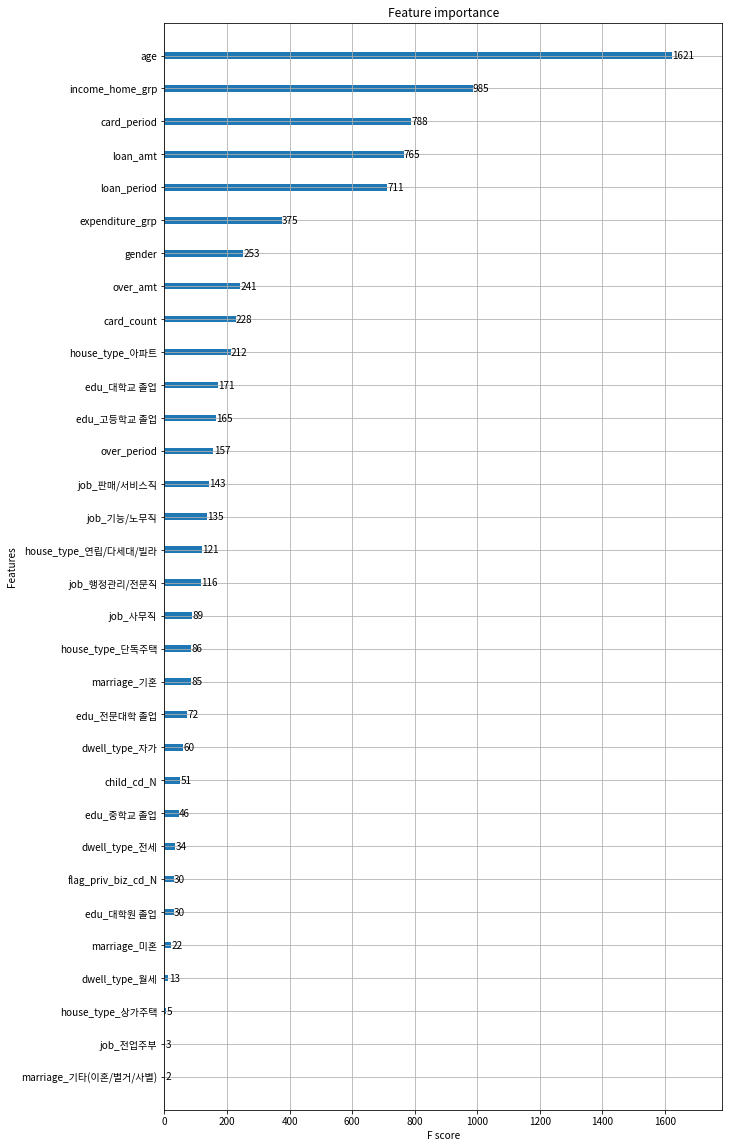

In [47]:
from xgboost import plot_importance

fig, ax = plt.subplots(1,1,figsize=(10,20))
plot_importance(xgb, ax = ax)